# DNA-alignment

Suppose we are given two strings $X$ and $Y$, where $X$ consists of the sequence of symbols $x_1, x_2 . . . x_m$ and $Y$ consists of the sequence of symbols $y_1$ , $y_2$ . . . $y_n$ . Consider the sets $\{1, 2, . . . , m\}$ and $\{1, 2, . . . , n\}$ as representing the different positions in the strings $X$ and $Y$, and consider a matching of these sets:

> a matching is a set of ordered pairs with the property that each item occurs in at most one pair. We say that a matching $M$ of these two sets is an alignment if there are no “crossing” pairs: if $(i, j), (i’, j’) \in M$ and $i < i’$ , then $j < j’$ . Intuitively, an alignment gives a way of lining up the two strings, by telling us which pairs of positions will be lined up with one another.

Our definition of similarity will be based on finding the optimal alignment between $X$ and $Y$, according to the following criteria. Suppose $M$ is a given alignment between $X$ and $Y$:

1. First, there is a parameter $\delta_e$ > 0 that defines a gap penalty. For each position of $X$ or $Y$ that is not matched in $M$ — it is a gap — we incur a cost of $\delta$. 
2. Second, for each pair of letters $p$, $q$ in our alphabet, there is a mismatch cost of $\alpha_{pq}$ for lining up $p$ with $q$. Thus, for each $(i, j)\in M$, we pay the appropriate mismatch cost $α_{x_iy_j}$ for lining up $x_i$ with $y_j$ . One generally assumes that $\alpha_{pp}$ = 0 for each letter $p$—there is no mismatch cost to line up a letter with another copy of itself.
3. The cost of $M$ is the sum of its gap and mismatch costs, and we seek an alignment of minimum cost.



We will implement the DNA-alignment using two approaches:

1. Basic version: Dynamic programming, time complexity $O(mn)$, space complexity $O(mn)$

2. Efficient version: Dynamic programming combined with Divide-and-Conquer, time complexity $O(mn)$ (but 2 times cpu time than pure dynamic programming), space complexity $O(n)$(if we choose to split $X$ in divide-and-conquer). DNA is usually a very very long string, ie $m$ and $n$ are very large. Therefore, this efficient version will save a factor of $m/2$ memory but only incur a factor of 2 cpu time, which is a good tradeoff. 

In [ ]:
#! /usr/bin/env python3
import numpy as np
import time
import psutil
import functools
import argparse
import tracemalloc
import pandas as pd
import numpy as np
import random
import os
import sys
import matplotlib.pyplot as plt
import random
import os
import pandas as pd
import sys

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

delta = 30
alpha = {"A": {"A":0,"C":110,"G":48,"T":94},
         "C": {"A":110,"C":0,"G":118,"T":48},
         "G": {"A":48,"C":118,"G":0,"T":110},
         "T": {"A":94,"C":48,"G":110,"T":0}}

In [2]:
def record_resource(func):
    @functools.wraps(func)
    def wrapped_func(*args, **kwargs):
        tracemalloc.start()
        start = time.time()
        out = func(*args, **kwargs)
        t = time.time()-start
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        return out, t, peak
    return wrapped_func

def generate_string(inputxt):
    """inputxt format
    1. First base string
    2. Next j lines would consist of indices corresponding the after which the
       previous string to be added to the cumulative string
    3. Second base string
    4. Next k lines would consist of where the base string to be added to the 
       cumulative string
    """
    bases, pos = [], []
    with open(inputxt, "r") as f:
        for line in f:
            line = line.strip()
            if line[0] in set(["A","T","C","G"]):
                if len(bases)!=0:
                    pos.append(tmp)
                    tmp = []
                else:
                    tmp = []
                bases.append(line)
            else:
                tmp.append(int(line))
        pos.append(tmp)
    res = []
    for i,seq in enumerate(bases):
        length = len(seq)
        for j in pos[i]:
            seq = seq[0:j+1]+seq+seq[j+1:]
        assert len(seq) == 2**len(pos[i])*length
        res.append(seq)
    return res

In [3]:
class BASIC:
    
    def __init__(self, X, Y, alpha, delta):
        self.X = X
        self.Y = Y
        self.alpha = alpha
        self.delta = delta
        self.opt = self.find_opt(X,Y,alpha,delta)
        self.seqx, self.seqy = self.get_sol(X, Y, self.opt)
        self.cost = str(float(self.opt[-1,-1]))
        
    def find_opt(self, X, Y, alpha, delta):
        m, n = len(X), len(Y)
        opt = np.full((n+1,m+1),np.inf)
        opt[0,:] = [k*delta for k in range(m+1)]
        opt[:,0] = [k*delta for k in range(n+1)]
        for i in range(1,n+1):
            for j in range(1,m+1):
                alt1 = opt[i-1,j-1]+alpha[Y[i-1]][X[j-1]] #mismatch
                alt2 = opt[i,j-1]+delta # X not in alignment
                alt3 = opt[i-1,j]+delta # Y not in alignment
                opt[i,j] = np.min([alt1, alt2, alt3]) # mismtach>X:"_" >Y:"_" when the cost are the same
        return opt
                
    def get_sol(self, X, Y, opt):
        # retrieve the optimal alignment
        seqx, seqy = "", ""
        opti, optj = len(Y), len(X)
        if opti == 0:
            return X, "_"*optj
        elif optj == 0:
            return "_"*opti, Y
        else:
            pass        
        while True:
            alt1, alt2, alt3 = np.inf, np.inf, np.inf
            if opti-1>=0 and optj-1>=0: #mismatch
                alt1 = opt[opti-1, optj-1] + alpha[Y[opti-1]][X[optj-1]]
            if optj-1>=0: # X aligned to "_"
                alt2 = opt[opti, optj-1] + delta
            if opti-1>=0:  # Y aligned to "_"
                alt3 = opt[opti-1, optj]+ delta
            index = np.argmin([alt1, alt2, alt3])
            if index == 0:
                seqx = X[optj-1]+seqx
                seqy = Y[opti-1]+seqy
                opti, optj =opti-1, optj-1
            elif index == 1:
                seqx = X[optj-1]+seqx
                seqy = "_" +seqy
                opti, optj =opti, optj-1
            else:
                seqx = "_"+seqx
                seqy = Y[opti-1] +seqy
                opti, optj =opti-1, optj
            if opti ==0 and optj ==0:
                break
        return seqx,seqy  

In [4]:
class EFFICIENT:
    
    def __init__(self, X, Y, alpha, delta):
        self.X = X
        self.Y = Y
        self.alpha = alpha
        self.delta = delta
        self.seqx, self.seqy, self.cost = self.divide_conquer(X,Y,alpha, delta)
        self.cost = str(float(self.cost))
        
    def find_opt(self, X, Y, alpha, delta):
        m, n = len(X), len(Y)
        r = min(2,n+1)
        opt = np.full((r,m+1),np.inf)
        opt[0,:] = [k*delta for k in range(m+1)]
        opt[:,0] = [k*delta for k in range(r)]
        for i in range(1,n+1):
            for j in range(m+1):
                alt1, alt2, alt3 = np.inf, np.inf, np.inf
                if i-1>=0 and j-1>=0: #mismatch
                    alt1 = opt[0,j-1]+alpha[Y[i-1]][X[j-1]]
                if j-1>=0:  #X aligned to "_"
                    alt2 = opt[1,j-1]+delta
                if i-1>=0:  #Y aligned to "_"
                    alt3 = opt[0,j]+delta
                opt[1,j] = np.min([alt1, alt2, alt3]) # mismtach>X:"_" >Y:"_" when the cost are the same
            if i!=n:
                opt[0,:] = opt[-1,:]
        return opt[-1,:] #opt[r-1,m]
    
    def divide_conquer(self, X,Y,alpha, delta): 
        m, n = len(X),len(Y)
        if m == 0:
            return "_"*n,Y, delta*n
        if m == 1:
            if n == 0:
                return X,"_",delta
            else:
                mismatch = np.array([alpha[X][i] for i in Y])
                index = np.argmin(mismatch)
                if mismatch[index]<=delta*2:
                    return "_"*index+X+"_"*(n-index-1), Y, mismatch[index]+(n-1)*delta
                else:
                    return "_"*n+X, Y+"_", delta*2+(n-1)*delta
        if n <= 1:
            ry, rx, cost = self.divide_conquer(Y, X, alpha, delta)
            return rx, ry, cost
        
        XL, XR = X[0:int(m/2)], X[int(m/2):]
        opt_left = self.find_opt(Y, XL, alpha, delta)
        opt_right = self.find_opt(Y[::-1], XR[::-1], alpha, delta)
        opt = opt_left+np.flip(opt_right, axis=0)
        opti = np.argmin(opt)
        cost = opt[opti]
        left_x, left_y, _ = self.divide_conquer(XL, Y[0:opti], alpha, delta)
        right_x, right_y, _ = self.divide_conquer(XR[::-1], Y[opti:][::-1], alpha, delta)
        seqx = left_x+right_x[::-1]
        seqy = left_y+right_y[::-1]
        return seqx, seqy, cost

In [5]:
@record_resource
def run(inputfile, func):
    X,Y = generate_string(inputfile)
    inst = func(X,Y,alpha,delta)
    cost = inst.cost
    return X, Y, inst.cost, inst.seqx, inst.seqy 

def main(inputfile, func, outdir):
    (X, Y, cost, seqx, seqy), t, peak = run(inputfile, func)
    os.system("mkdir -p "+outdir)
    outfile = outdir+"/output.txt"
    with open(outfile, "w") as f:
        f.write(seqx[0:50]+" "+seqx[-50:]+"\n")
        f.write(seqy[0:50]+" "+seqy[-50:]+"\n")
        f.write(str(cost)+"\n"+str(t)+"\n"+str(peak)+"\n")
    return np.array([len(X), len(Y),  len(X)+len(Y), cost, t, peak])

In [6]:
def my_plotter(x, y1, y2, **kwargs):
    fig, ax = plt.subplots()  
    ax.plot(x, y1,'o-', label='basic_solution')
    ax.plot(x, y2,'o-', label='efficient_solution')
    ax.set_xlabel("problem_size")
    ax.set_ylabel(kwargs["ylabel"])
    ax.set_title(kwargs["title"])
    ax.legend()
    fig.savefig("a.png",dpi=480,bbox_inches='tight',transparent=False, pad_inches=0)

In [10]:
def simulation(max_base_num, max_line_num, num, outdir):
    os.system("mkdir -p "+outdir)
    n=1
    while n <= num:
        xbase = random.choices("ATCG", k=random.choice(range(2,max_base_num)))
        ybase = random.choices("ATCG", k=random.choice(range(2,max_base_num)))
        xline = [random.choice(range(2**i*len(xbase))) for i in range(random.choice(range(4,max_line_num)))]
        yline = [random.choice(range(2**i*len(ybase))) for i in range(random.choice(range(4,max_line_num)))]
        with open(outdir+"/input"+str(n)+".txt", "w") as f:
            f.write("".join(xbase)+"\n")
            if xline!=[]:
                f.write("\n".join([str(i) for i in xline])+"\n")
            f.write("".join(ybase)+"\n")
            if yline!=[]:
                f.write("\n".join([str(i) for i in yline])+"\n")
        n = n+1
    return os.path.abspath(outdir)
simulation_dir = simulation(max_base_num=6, max_line_num=8, num=100, outdir=os.getcwd()+"/simulation")

In [11]:
result = np.zeros((100,9))
for i in range(100):
    print(i,end=", ")
    result[i,0:6] = main(simulation_dir+"/input"+str(i+1)+".txt", BASIC, simulation_dir+"/basic_output"+str(i+1))
    temp = main(simulation_dir+"/input"+str(i+1)+".txt", EFFICIENT, simulation_dir+"/efficient_output"+str(i+1))
    result[i,6:9] = temp[3:6]
result = pd.DataFrame(result)
result.columns = ["m","n","problem_size","cost_basic","time_basic","mem_basic","cost_efficient","time_efficient","mem_efficient"]
result = result.sort_values(by="problem_size")
assert sum(result["cost_basic"] == result["cost_efficient"])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

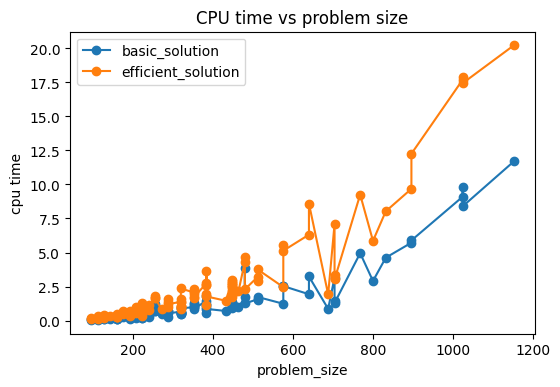

In [12]:
my_plotter(result["problem_size"], result["time_basic"], result["time_efficient"], ylabel="cpu time", title="CPU time vs problem size")

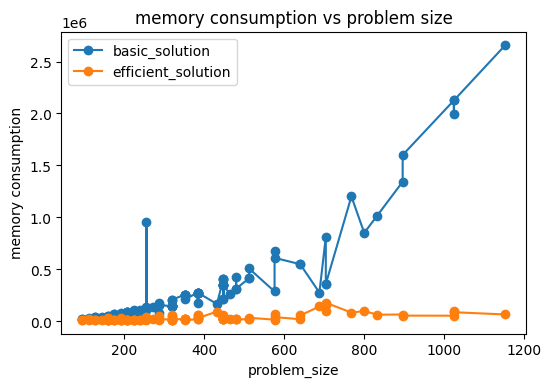

In [13]:
my_plotter(result["problem_size"], result["mem_basic"], result["mem_efficient"], ylabel="memory consumption", title="memory consumption vs problem size")

In [14]:
def main(inputfile, func, outdir):
    (X, Y, cost, seqx, seqy), t, peak = run(inputfile, func)
    os.system("mkdir -p "+outdir)
    outfile = outdir+"/output.txt"
    with open(outfile, "w") as f:
        f.write(seqx[0:50]+" "+seqx[-50:]+"\n")
        f.write(seqy[0:50]+" "+seqy[-50:]+"\n")
        f.write(str(cost)+"\n"+str(t)+"\n"+str(peak)+"\n")
    with open(outfile,"r") as f:
        content = f.readlines()
    return "".join(content)

In [18]:
print(main("input.txt", BASIC, "./"))

_______ACACACTG__ACTAC_TGACTG_GTGA__C_TACTGACTGGAC GTGA__C_TACTGACTGGACTGACTACTGACTGGTGACTAC_TGACTG_G
TATTATTATACGCTATTA_TACGCGAC_GCG_GACGCGTA_T_AC__G_C G_GACGCGTA_T_AC__G_CT_ATTA_T_AC__GCGAC_GCG_GAC_GCG
1296.0
0.15212202072143555
38446



In [19]:
inst = BASIC("","",alpha,delta)
print(inst.seqx, inst.seqy, inst.cost)

  0.0


In [20]:
inst = EFFICIENT("","",alpha,delta)
print(inst.seqx, inst.seqy, inst.cost)

  0.0


In [21]:
for i in ["","A","T","C","G"]:
    inst = BASIC("",i,alpha,delta)
    print(inst.seqx, inst.seqy, inst.cost, end =" | ")
for i in ["", "A","T","C","G"]:
    inst = BASIC(i,"",alpha,delta)
    print(inst.seqx, inst.seqy, inst.cost, end =" | ")
print("\n#")
for i in ["", "A","T","C","G"]:
    inst = EFFICIENT("",i,alpha,delta)
    print(inst.seqx, inst.seqy, inst.cost, end =" | ")
for i in ["","A","T","C","G"]:
    inst = EFFICIENT(i,"",alpha,delta)
    print(inst.seqx, inst.seqy, inst.cost, end =" | ")

  0.0 | _ A 30.0 | _ T 30.0 | _ C 30.0 | _ G 30.0 |   0.0 | A _ 30.0 | T _ 30.0 | C _ 30.0 | G _ 30.0 | 
#
  0.0 | _ A 30.0 | _ T 30.0 | _ C 30.0 | _ G 30.0 |   0.0 | A _ 30.0 | T _ 30.0 | C _ 30.0 | G _ 30.0 | 